# Задача классификации автомобилей по фотографиям.

In [1]:
# Загрузка модели efficientnet
!pip install efficientnet
# Устанавливаем библиотеку аугументации albuminations
!pip install git+https://github.com/mjkvaak/ImageDataAugmentor

     |████████████████████████████████| 50 kB 718 kB/s eta 0:00:01
  Cloning https://github.com/mjkvaak/ImageDataAugmentor to /tmp/pip-req-build-xs1xvvfi
  Running command git clone -q https://github.com/mjkvaak/ImageDataAugmentor /tmp/pip-req-build-xs1xvvfi
     |████████████████████████████████| 113 kB 879 kB/s eta 0:00:01
     |████████████████████████████████| 60.9 MB 67.6 MB/s eta 0:00:01     |██████████████████████████▋     | 50.6 MB 67.6 MB/s eta 0:00:01
  Created wheel for ImageDataAugmentor: filename=ImageDataAugmentor-0.0.0-py3-none-any.whl size=29630 sha256=9edb294aa1c2680b67c2429108c66c2260eb602406e432084de4dac2023e2be2
  Stored in directory: /tmp/pip-ephem-wheel-cache-_vhfq629/wheels/c9/bd/73/9cfa59d2393dae55bbcc30f5aa901f55fe531c66efebbc8fc3
Successfully built ImageDataAugmentor
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.5.2.54
    Uninstalling opencv-python-4.5.2.54:
      Successfully uninstalled opencv-python-4.5.2.54
  Attem

### Импорт библиотек.

In [2]:
import os 
import re 
import math
import random
import time
import gc
import string
import pickle
import shutil
import pathlib
import itertools
import zipfile
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import PIL

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import *
from tensorflow.keras.activations import *
from tensorflow.keras.applications import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.layers import *
from tensorflow.keras.layers.experimental.preprocessing import *
from tensorflow.keras.losses import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.optimizers.schedules import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.backend import clear_session
from tensorflow.keras.applications import efficientnet as efn

from PIL import Image
from IPython.display import clear_output
from tqdm.notebook import tqdm

from ImageDataAugmentor.image_data_augmentor import *
import albumentations as A

# Переменные

In [3]:
EPOCHS               = 10
BATCH_SIZE           = 32
LR                   = 1e-4
VAL_SPLIT            = 0.2
RANDOM_SEED          = 42

CLASS_NUM            = 10
IMG_SIZE             = 224 #320
IMG_CHANNELS         = 3
input_shape          = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)

# Загрузка данных:

In [4]:
train_df = pd.read_csv('../input/sf-dl-car-classification/train.csv')
sample_submission = pd.read_csv('../input/sf-dl-car-classification/sample-submission.csv')
train_df.head()

,Id,Category
0,100155.jpg,0
1,100306.jpg,0
2,100379.jpg,0
3,100380.jpg,0
4,100389.jpg,0


In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15561 entries, 0 to 15560
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Id        15561 non-null  object
 1   Category  15561 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 243.3+ KB


In [6]:
train_df.Category.value_counts()

1    1971
8    1765
6    1733
5    1631
0    1613
3    1528
2    1458
4    1400
9    1255
7    1207
Name: Category, dtype: int64

Распределение классов достаточно равномерное - это хорошо.

In [7]:
print('Распаковываем картинки')

for data_zip in ['train.zip', 'test.zip']:
    with zipfile.ZipFile("../input/sf-dl-car-classification/"+data_zip,"r") as z:
        z.extractall('../')
        
print(os.listdir('../'))

Распаковываем картинки
['test_upload', 'lib', 'input', 'train', 'working']


Пример картинок (random sample)


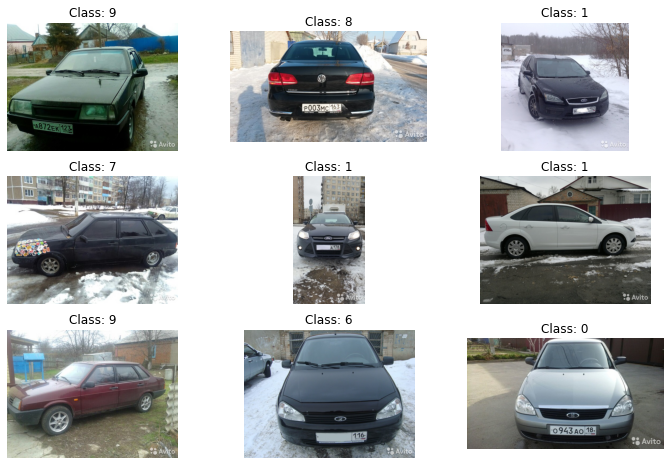

In [8]:
print('Пример картинок (random sample)')
plt.figure(figsize=(12,8))

random_image = train_df.sample(n=9)
random_image_paths = random_image['Id'].values
random_image_cat = random_image['Category'].values

for index, path in enumerate(random_image_paths):
    im = PIL.Image.open('../' + f'train/{random_image_cat[index]}/{path}')
    plt.subplot(3,3, index+1)
    plt.imshow(im)
    plt.title('Class: ' + str(random_image_cat[index]))
    plt.axis('off')
plt.show()

Посмотрим на примеры картинок и их размеры чтоб понимать как их лучше обработать и сжимать.

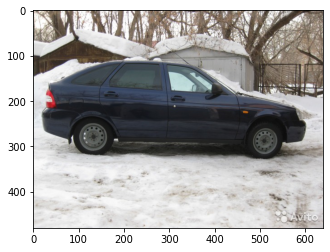

(640, 480)

In [9]:
image = PIL.Image.open('../train/0/100380.jpg')
imgplot = plt.imshow(image)
plt.show()
image.size

# Подготовка данных

## Аугментация

In [10]:
AUGMENTATIONS = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=30, interpolation=1, border_mode=4, value=None, mask_value=None, always_apply=False, p=0.5),
    A.OneOf([
        A.CenterCrop(height=224, width=200),
        A.CenterCrop(height=200, width=224),
    ],p=0.5),
    A.OneOf([
        A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3),
        A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1)
    ],p=0.5),
    A.GaussianBlur(p=0.05),
    A.HueSaturationValue(p=0.5),
    A.RGBShift(),
    A.FancyPCA(alpha=0.1, always_apply=False, p=0.5),
    A.Resize(IMG_SIZE, IMG_SIZE)
])

In [11]:
train_datagen = ImageDataGenerator(
                                   AUGMENTATIONS,
                                   #rescale = 1/255,
                                   validation_split = VAL_SPLIT,
                                   )

test_datagen = ImageDataGenerator(
                                    #rescale = 1/255
                                 )

In [12]:
train_generator = train_datagen.flow_from_directory(
    '../train/', 
    target_size = (IMG_SIZE, IMG_SIZE),
    batch_size = BATCH_SIZE,
    class_mode = 'categorical',
    shuffle = True, seed = RANDOM_SEED,
    subset = 'training')

test_generator = train_datagen.flow_from_directory(
    '../train/',
    target_size = (IMG_SIZE, IMG_SIZE),
    batch_size = BATCH_SIZE,
    class_mode = 'categorical',
    shuffle = True, seed = RANDOM_SEED,
    subset = 'validation')

test_sub_generator = test_datagen.flow_from_dataframe( 
    dataframe = sample_submission,
    directory = '../test_upload/',
    x_col = "Id",
    y_col = None,
    shuffle = False,
    class_mode = None,
    seed = 0,
    target_size = (IMG_SIZE, IMG_SIZE),
    batch_size = BATCH_SIZE)

Found 12452 images belonging to 10 classes.
Found 3109 images belonging to 10 classes.
Found 6675 validated image filenames.


Генератор выдал 12452 картинки для трэйна и 3109 - для теста. Каждая часть данных имеет по 10 классов. Также мы получили 6675 картинок для сабмишна. Посмотрим на некоторые случайные фото из train_generator.

/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Пример картинок из train_generator


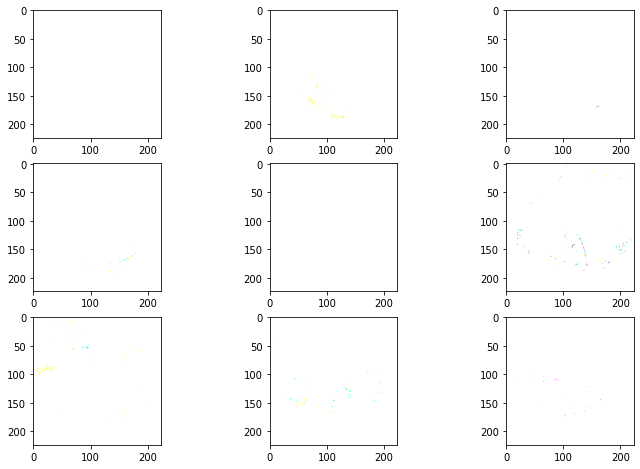

In [13]:
from skimage import io

def imshow(image_RGB):
    io.imshow(image_RGB)
    io.show()

x,y = train_generator.next()
print('Пример картинок из train_generator')
plt.figure(figsize=(12,8))

for i in range(0,9):
    image = x[i]
    plt.subplot(3,3, i+1)
    plt.imshow(image)
    #plt.title('Class: '+str(y[i]))
    #plt.axis('off')
plt.show()

## Построение модели

Для построения модели возьмем предобученную сеть **EfficientNetB6** .

In [14]:
clear_session()

Обучим модель с тонкой настройкой (fine-tuning).

In [15]:
base_model = efn.EfficientNetB6(weights = 'imagenet', include_top=False, input_shape = (input_shape))

165240832/165234480 [==============================] - 1s 0us/step


Замораживаем веса EfficientNetB6 и обучаем голову, чтобы не затереть веса Imagenet

In [16]:
base_model.trainable = False

Добавляем ее в общую структуру.

In [17]:
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.25), 
    Dense(CLASS_NUM, activation='softmax')
])

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb6 (Functional)  (None, 7, 7, 2304)        40960143  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2304)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               590080    
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                2570      
Total params: 41,553,817
Trainable params: 593,162
Non-trainable params: 40,960,655
______________________________________

In [19]:
for layer in model.layers:
    print(layer, layer.trainable)

<tensorflow.python.keras.engine.functional.Functional object at 0x7f4b0451c450> False
<tensorflow.python.keras.layers.pooling.GlobalAveragePooling2D object at 0x7f4ac05aeb90> True
<tensorflow.python.keras.layers.core.Dense object at 0x7f4ac0667790> True
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f4ac0667110> True
<tensorflow.python.keras.layers.core.Dropout object at 0x7f4ac05a6090> True
<tensorflow.python.keras.layers.core.Dense object at 0x7f4ac05a6490> True


## Обучение модели

In [20]:
model.compile(loss = CategoricalCrossentropy(from_logits = True), optimizer = Adam(ExponentialDecay(LR, 100, 0.9)), 
              metrics='accuracy')

Добавим ModelCheckpoint чтоб сохранять прогресс обучения модели и можно было потом подгрузить и дообучить модель.

In [21]:
checkpoint = ModelCheckpoint('best_model.hdf5' , monitor = ['val_accuracy'] , verbose = 1  , mode = 'max')
early_stopping = EarlyStopping(monitor='accuracy', patience=5, verbose = 1, restore_best_weights=True)

callbacks_list = [
    checkpoint, 
    early_stopping
]

Обучаем:

In [22]:
history = model.fit(
    train_generator, 
    steps_per_epoch = len(train_generator), 
    validation_data = test_generator, 
    validation_steps = len(test_generator), 
    epochs = EPOCHS, 
    callbacks = callbacks_list
)

Epoch 1/10
390/390 [==============================] - 134s 291ms/step - loss: 1.9164 - accuracy: 0.3702 - val_loss: 1.1445 - val_accuracy: 0.6127

Epoch 00001: saving model to best_model.hdf5
Epoch 2/10
390/390 [==============================] - 109s 280ms/step - loss: 1.1647 - accuracy: 0.5941 - val_loss: 0.9485 - val_accuracy: 0.6722

Epoch 00002: saving model to best_model.hdf5
Epoch 3/10
390/390 [==============================] - 109s 278ms/step - loss: 1.0104 - accuracy: 0.6465 - val_loss: 0.8753 - val_accuracy: 0.6935

Epoch 00003: saving model to best_model.hdf5
Epoch 4/10
390/390 [==============================] - 109s 279ms/step - loss: 0.9461 - accuracy: 0.6654 - val_loss: 0.8338 - val_accuracy: 0.7089

Epoch 00004: saving model to best_model.hdf5
Epoch 5/10
390/390 [==============================] - 109s 279ms/step - loss: 0.9021 - accuracy: 0.6788 - val_loss: 0.8142 - val_accuracy: 0.7144

Epoch 00005: saving model to best_model.hdf5
Epoch 6/10
390/390 [====================

In [23]:
# сохраним итоговую сеть и подгрузим лучшую итерацию в обучении (best_model)
model.save('../working/model_last.hdf5')
model.load_weights('best_model.hdf5')

In [24]:
scores = model.evaluate(test_generator, steps=len(test_generator), verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

98/98 [==============================] - 22s 217ms/step - loss: 0.7865 - accuracy: 0.7247
Accuracy: 72.47%


Посмотрим на графики обучения:

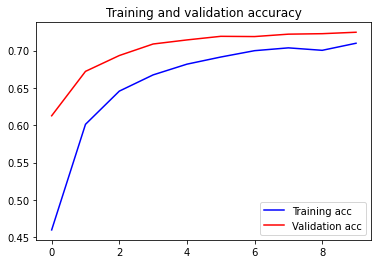

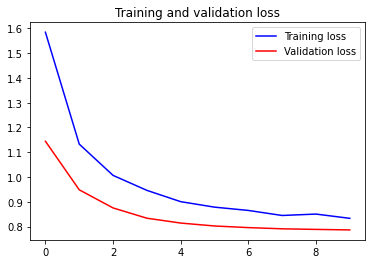

In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

## FineTuning

Посмотрим сколько слоев в базовой модели.

In [26]:
len(base_model.layers)

666

### Разморозим половину слоев и снова обучим сеть.

In [27]:
base_model.trainable = True
fine_tune_at = len(base_model.layers)//2

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

In [28]:
len(base_model.trainable_variables)

292

In [29]:
EPOCHS               = 10
BATCH_SIZE           = 16
LR                   = 1e-4

In [30]:
model.compile(loss = CategoricalCrossentropy(from_logits = True), optimizer = Adam(ExponentialDecay(LR, 100, 0.9)), 
              metrics='accuracy')

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb6 (Functional)  (None, 7, 7, 2304)        40960143  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2304)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               590080    
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                2570      
Total params: 41,553,817
Trainable params: 38,414,048
Non-trainable params: 3,139,769
____________________________________

In [31]:
history = model.fit(
    train_generator, 
    steps_per_epoch = len(train_generator), 
    validation_data = test_generator, 
    validation_steps = len(test_generator), 
    epochs = EPOCHS, 
    callbacks = callbacks_list
)

Epoch 1/10
390/390 [==============================] - 178s 408ms/step - loss: 1.3719 - accuracy: 0.5386 - val_loss: 0.3813 - val_accuracy: 0.8646

Epoch 00001: saving model to best_model.hdf5
Epoch 2/10
390/390 [==============================] - 156s 399ms/step - loss: 0.2631 - accuracy: 0.9081 - val_loss: 0.2992 - val_accuracy: 0.8955

Epoch 00002: saving model to best_model.hdf5
Epoch 3/10
390/390 [==============================] - 154s 396ms/step - loss: 0.1343 - accuracy: 0.9556 - val_loss: 0.2690 - val_accuracy: 0.9038

Epoch 00003: saving model to best_model.hdf5
Epoch 4/10
390/390 [==============================] - 155s 396ms/step - loss: 0.0862 - accuracy: 0.9732 - val_loss: 0.2607 - val_accuracy: 0.9096

Epoch 00004: saving model to best_model.hdf5
Epoch 5/10
390/390 [==============================] - 156s 399ms/step - loss: 0.0621 - accuracy: 0.9804 - val_loss: 0.2529 - val_accuracy: 0.9135

Epoch 00005: saving model to best_model.hdf5
Epoch 6/10
390/390 [====================

In [32]:
model.save('../working/model_last.hdf5')
model.load_weights('best_model.hdf5')

In [33]:
scores = model.evaluate(test_generator, steps=len(test_generator), verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

98/98 [==============================] - 22s 222ms/step - loss: 0.2499 - accuracy: 0.9180
Accuracy: 91.80%


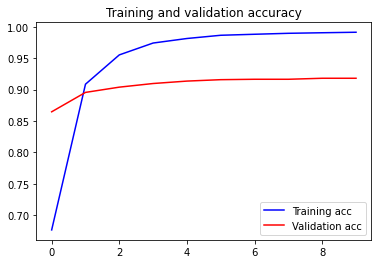

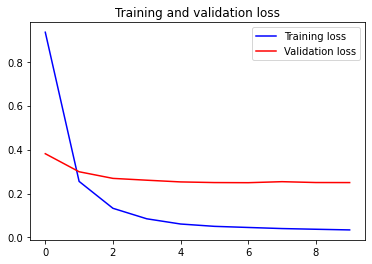

In [34]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

### Разморозим всю сеть.

In [35]:
EPOCHS               = 10
BATCH_SIZE           = 8
LR                   = 1e-5

In [36]:
base_model.trainable = True

model.compile(loss = CategoricalCrossentropy(from_logits = True), optimizer = Adam(ExponentialDecay(LR, 100, 0.9)), 
              metrics='accuracy')

Снова обучим сеть.

In [37]:
history = model.fit(
    train_generator, 
    steps_per_epoch = len(train_generator), 
    validation_data = test_generator, 
    validation_steps = len(test_generator), 
    epochs = EPOCHS, 
    callbacks = callbacks_list
)

Epoch 1/10
390/390 [==============================] - 382s 922ms/step - loss: 0.1159 - accuracy: 0.9568 - val_loss: 0.2563 - val_accuracy: 0.9122

Epoch 00001: saving model to best_model.hdf5
Epoch 2/10
390/390 [==============================] - 356s 913ms/step - loss: 0.0817 - accuracy: 0.9724 - val_loss: 0.2451 - val_accuracy: 0.9135

Epoch 00002: saving model to best_model.hdf5
Epoch 3/10
390/390 [==============================] - 356s 914ms/step - loss: 0.0694 - accuracy: 0.9775 - val_loss: 0.2415 - val_accuracy: 0.9167

Epoch 00003: saving model to best_model.hdf5
Epoch 4/10
390/390 [==============================] - 356s 912ms/step - loss: 0.0550 - accuracy: 0.9844 - val_loss: 0.2400 - val_accuracy: 0.9193

Epoch 00004: saving model to best_model.hdf5
Epoch 5/10
390/390 [==============================] - 356s 912ms/step - loss: 0.0533 - accuracy: 0.9838 - val_loss: 0.2388 - val_accuracy: 0.9193

Epoch 00005: saving model to best_model.hdf5
Epoch 6/10
390/390 [====================

In [38]:
model.save('../working/model_last.hdf5')
model.load_weights('best_model.hdf5')

In [39]:
scores = model.evaluate(test_generator, steps=len(test_generator), verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

98/98 [==============================] - 22s 219ms/step - loss: 0.2365 - accuracy: 0.9212
Accuracy: 92.12%


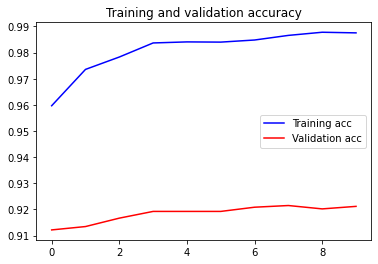

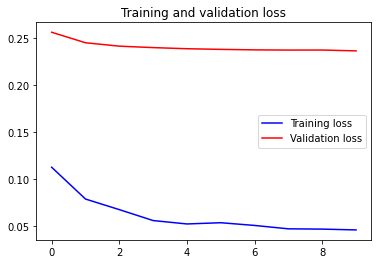

In [40]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

### Увеличим размер изображения и понизим уровень аугментации

In [41]:
IMG_SIZE             = 512
BATCH_SIZE           = 4
LR                   = 1e-5
EPOCHS               = 8

In [42]:
AUGMENTATIONS = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=30, interpolation=1, border_mode=4, value=None, mask_value=None, always_apply=False, p=0.5)
])

train_datagen = ImageDataAugmentor(
        AUGMENTATIONS,
        #rescale=1./255,
        validation_split=VAL_SPLIT,
        )

test_datagen = ImageDataAugmentor(
                                    #rescale=1./255
                                 )

In [43]:
train_generator = train_datagen.flow_from_directory(
    '../train/', 
    target_size = (IMG_SIZE, IMG_SIZE),
    batch_size = BATCH_SIZE,
    class_mode = 'categorical',
    shuffle = True, seed = RANDOM_SEED,
    subset = 'training')

test_generator = train_datagen.flow_from_directory(
    '../train/',
    target_size = (IMG_SIZE, IMG_SIZE),
    batch_size = BATCH_SIZE,
    class_mode = 'categorical',
    shuffle = True, seed = RANDOM_SEED,
    subset = 'validation')

test_sub_generator = test_datagen.flow_from_dataframe( 
    dataframe = sample_submission,
    directory = '../test_upload/',
    x_col = "Id",
    y_col = None,
    shuffle = False,
    class_mode = None,
    seed = 0,
    target_size = (IMG_SIZE, IMG_SIZE),
    batch_size = BATCH_SIZE)

/opt/conda/lib/python3.7/site-packages/ImageDataAugmentor/image_data_augmentor.py:333: UserWarning: Passing `seed` in `.flow_from_directory` has been been removed: pass  `seed` as parameter in `ImageDataAugmentor(..., seed=...)` instead
  warnings.warn('Passing `seed` in `.flow_from_directory` has been been removed: pass  `seed` '


Found 12452 images belonging to 10 classes.
Found 3109 images belonging to 10 classes.
Found 6675 validated image filenames.


/opt/conda/lib/python3.7/site-packages/ImageDataAugmentor/image_data_augmentor.py:456: UserWarning: Passing `seed` in `.flow_from_datagrame` has been been removed: pass  `seed` as parameter in `ImageDataAugmentor(..., seed=...)` instead
  warnings.warn('Passing `seed` in `.flow_from_datagrame` has been been removed: pass  `seed` '


In [44]:
base_model = efn.EfficientNetB6(weights = 'imagenet', include_top=False, input_shape = (input_shape))

In [45]:
model.compile(loss = CategoricalCrossentropy(from_logits = True), optimizer = Adam(ExponentialDecay(LR, 100, 0.9)), 
              metrics='accuracy')

In [46]:
model.load_weights('best_model.hdf5')

In [47]:
history = model.fit(
    train_generator, 
    steps_per_epoch = len(train_generator), 
    validation_data = test_generator, 
    validation_steps = len(test_generator), 
    epochs = EPOCHS, 
    callbacks = callbacks_list
)

/opt/conda/lib/python3.7/site-packages/ImageDataAugmentor/image_data_augmentor.py:538: UserWarning: This ImageDataAugmentor specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataAugmentor specifies '


Epoch 1/8
3113/3113 [==============================] - 2147s 682ms/step - loss: 0.7579 - accuracy: 0.7695 - val_loss: 0.1948 - val_accuracy: 0.9382

Epoch 00001: saving model to best_model.hdf5
Epoch 2/8
3113/3113 [==============================] - 2123s 682ms/step - loss: 0.5304 - accuracy: 0.8277 - val_loss: 0.1986 - val_accuracy: 0.9360

Epoch 00002: saving model to best_model.hdf5
Epoch 3/8
3113/3113 [==============================] - 2120s 681ms/step - loss: 0.5401 - accuracy: 0.8297 - val_loss: 0.1948 - val_accuracy: 0.9373

Epoch 00003: saving model to best_model.hdf5
Epoch 4/8
3113/3113 [==============================] - 2118s 680ms/step - loss: 0.5517 - accuracy: 0.8281 - val_loss: 0.1975 - val_accuracy: 0.9363

Epoch 00004: saving model to best_model.hdf5
Epoch 5/8
3113/3113 [==============================] - 2123s 682ms/step - loss: 0.5248 - accuracy: 0.8251 - val_loss: 0.1956 - val_accuracy: 0.9353

Epoch 00005: saving model to best_model.hdf5
Epoch 6/8
3113/3113 [=========

In [48]:
model.save('../working/model_last.hdf5')
model.load_weights('best_model.hdf5')

In [49]:
scores = model.evaluate(test_generator, steps=len(test_generator), verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

778/778 [==============================] - 87s 112ms/step - loss: 0.1964 - accuracy: 0.9347
Accuracy: 93.47%


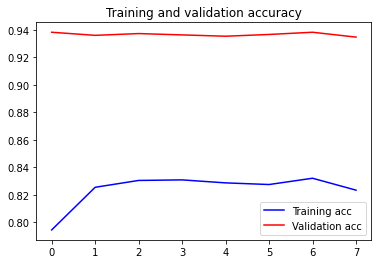

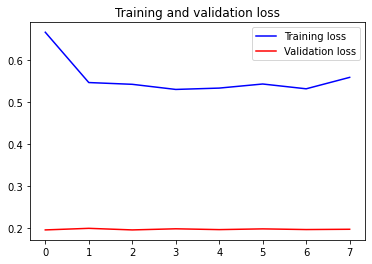

In [50]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

### Test-time augmentations (TTA)

In [51]:
model.load_weights('best_model.hdf5')

In [52]:
AUGMENTATIONS = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=30, interpolation=1, border_mode=4, value=None, mask_value=None, always_apply=False, p=0.5),
    A.OneOf([
        albumentations.CenterCrop(height=224, width=200),
        albumentations.CenterCrop(height=200, width=224),
    ],p=0.5),
    A.OneOf([
        A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3),
        A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1)
    ],p=0.5),
    A.GaussianBlur(p=0.05),
    A.HueSaturationValue(p=0.5),
    A.RGBShift(p=0.5),
    A.FancyPCA(alpha=0.1, always_apply=False, p=0.5),
    A.Resize(IMG_SIZE, IMG_SIZE)
])
      
test_datagen = ImageDataAugmentor( 
    #rescale=1./255,
    AUGMENTATIONS,
    validation_split=VAL_SPLIT,
)

In [53]:
test_sub_generator = test_datagen.flow_from_dataframe( 
    dataframe = sample_submission,
    directory = '../test_upload/',
    x_col = "Id",
    y_col = None,
    shuffle = False,
    class_mode = None,
    seed = 0,
    target_size = (IMG_SIZE, IMG_SIZE),
    batch_size = BATCH_SIZE)

Found 6675 validated image filenames.


In [54]:
tta_steps = 10 # берем среднее из 10 предсказаний
predictions = []

for i in range(tta_steps):
    preds = model.predict_generator(test_sub_generator, steps=len(test_sub_generator), verbose=1) 
    predictions.append(preds)

pred = np.mean(predictions, axis=0)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


1669/1669 [==============================] - 183s 110ms/step


In [55]:
predictions = np.argmax(pred, axis=-1)
label_map = (train_generator.class_indices)
label_map = dict((v,k) for k,v in label_map.items())
predictions = [label_map[k] for k in predictions]

In [59]:
filenames_with_dir=test_sub_generator.filenames
submission = pd.DataFrame({'Id':filenames_with_dir, 'Category':predictions}, columns=['Id', 'Category'])
submission['Id'] = submission['Id'].replace('test_upload/','')
submission.to_csv('submission_TTA.csv', index=False)
print('Save submit')

Save submit


In [57]:
# # Clean PATH
# import shutil
# shutil.rmtree(PATH)

In [58]:
# submission.head()